In [1]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2023-08-28 06:44:40--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2023-08-28 06:44:40--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2023-08-28 06:44:41--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Perman

In [2]:
import os

image_path = "./images"
target_path = "./annotations/trimaps"

input_img_paths = sorted([os.path.join(image_path, path) for path in os.listdir(image_path) if path.endswith(".jpg")])
target_paths = sorted([os.path.join(target_path, path) for path in os.listdir(target_path) if path.endswith(".png") and not path.startswith(".")])

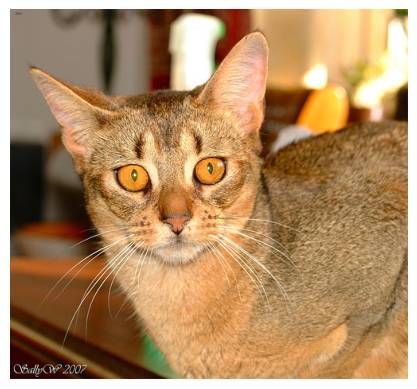

In [3]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

img = load_img(input_img_paths[4])
plt.axis('off')
plt.imshow(img)

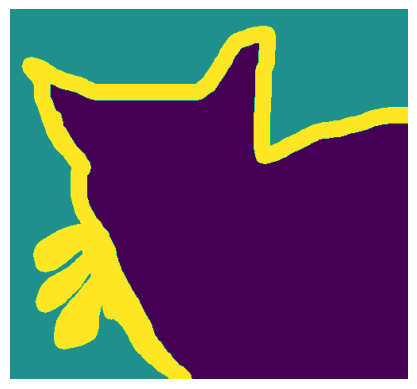

In [4]:
def display_target(target_array):
  normalized_array = (target_array.astype("uint8") - 1) * 127
  plt.axis('off')
  plt.imshow(target_array[:, :, 0])

img = img_to_array(load_img(target_paths[4], color_mode="grayscale"))
display_target(img)

In [5]:
import numpy as np
import random

img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
  return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
  img = img_to_array(load_img(path, target_size=img_size, color_mode="grayscale"))
  img = img.astype("uint8") - 1
  return img


input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")

for i in range(num_imgs):
  input_imgs[i] = path_to_input_image(input_img_paths[i])
  targets[i] = path_to_target(target_paths[i])

In [6]:
validation_size = 1000

train_input_imgs = input_imgs[:-validation_size]
train_targets = targets[:-validation_size]
val_input_imgs = input_imgs[-validation_size:]
val_targets = targets[-validation_size:]

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
  inputs = keras.Input(shape=img_size + (3,))
  x = layers.Rescaling(1./255)(inputs) #이거 안하면 어케됨?

  x = layers.Conv2D(64, 3, strides=2, activation='relu', padding="same")(x)
  x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
  x = layers.Conv2D(128, 3, strides=2, activation='relu', padding="same")(x)
  x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
  x = layers.Conv2D(256, 3, strides=2, activation='relu', padding="same")(x)
  x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)

  x = layers.Conv2DTranspose(256, 3, activation='relu', padding='same')(x)
  x = layers.Conv2DTranspose(256, 3, activation='relu', padding='same', strides=2)(x)
  x = layers.Conv2DTranspose(128, 3, activation='relu', padding='same')(x)
  x = layers.Conv2DTranspose(128, 3, activation='relu', padding='same', strides=2)(x)
  x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
  x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same', strides=2)(x)

  outputs = layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

model = get_model(img_size, 3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

In [8]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
callbacks = [keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)]

history = model.fit(train_input_imgs, train_targets,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data = (val_input_imgs, val_targets))

Epoch 1/50
100/100 [==============================] - 100s 747ms/step - loss: 0.9452 - val_loss: 1.1735
Epoch 2/50
100/100 [==============================] - 60s 596ms/step - loss: 0.8960 - val_loss: 0.8403
Epoch 3/50
100/100 [==============================] - 60s 602ms/step - loss: 0.8362 - val_loss: 0.7934
Epoch 4/50
100/100 [==============================] - 60s 601ms/step - loss: 0.8157 - val_loss: 0.7622
Epoch 5/50
100/100 [==============================] - 60s 602ms/step - loss: 0.7785 - val_loss: 0.8716
Epoch 6/50
100/100 [==============================] - 60s 602ms/step - loss: 0.7651 - val_loss: 0.7361
Epoch 7/50
100/100 [==============================] - 60s 602ms/step - loss: 0.7539 - val_loss: 0.7723
Epoch 8/50
100/100 [==============================] - 60s 602ms/step - loss: 0.7412 - val_loss: 0.7429
Epoch 9/50
100/100 [==============================] - 60s 604ms/step - loss: 0.7149 - val_loss: 0.6939
Epoch 10/50
100/100 [==============================] - 60s 604ms/step - 

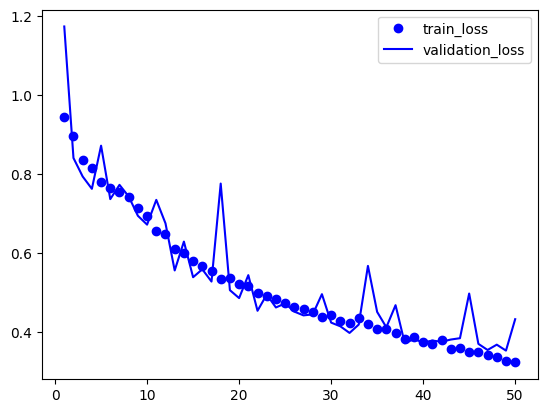

In [9]:
epochs = range(1, 51)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.plot(epochs, loss, "bo", label="train_loss")
plt.plot(epochs, val_loss, "b", label="validation_loss")
plt.legend()
plt.show()

In [16]:
mask = model.predict(train_input_imgs[0].reshape(1, 200, 200, 3))
mask.shape

1/1 [==============================] - 1s 648ms/step


(1, 200, 200, 3)

1/1 [==============================] - 0s 20ms/step


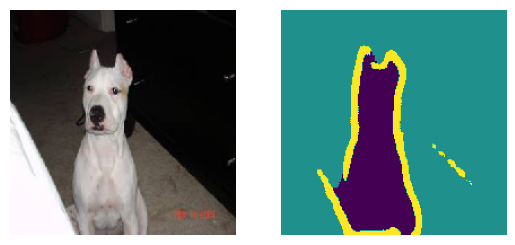

In [39]:
from tensorflow.keras.utils import array_to_img


def display_mask(i):
  test_img = val_input_imgs[i]
  mask = model.predict(test_img.reshape(1, 200, 200, 3))[0]
  mask = np.argmax(mask, axis=-1)
  mask *= 127

  f, ax = plt.subplots(1, 2)
  ax[0].axis('off')
  ax[1].axis('off')
  ax[0].imshow(array_to_img(test_img))
  ax[1].imshow(mask)

display_mask(4)